# Convolutional Networks


## Convolutional Architectures
When modelling an image using a regular feed-forward network, the number of parameters quickly gets huge. You will see this if you calculated how many parameters there are in a feed-forward network with 2 hidden layers consisting of say, 200 neurons each, an output size of 10 and an input image of shape [32, 32, 3]? (Note that we represent each pixel in a a colour image using three real-numbers for the Red, Green and Blue values and hence the 32x32**x3** shape.)

ConvNets address this model parameter issue by exploiting structure in the inputs to the network (in particular, by making the assumption that the input is a 3-D *volume*, which applies to images for example, where the 3 dimensions consist of the three RGB channels). The two key differences between a ConvNet and a Feed-forward network are:

* ConvNets have neurons that are arranged in 3 dimensions: width, height, depth. Note that *depth* here means channels, i.e. the depth of the input volume, not the depth of a deep neural network!
* The neurons in each layer are only connected to a small region of the layer before it.



## The CIFAR10 Dataset
We will combine what we've learned about convolution, max-pooling and feed-forward layers, to build a ConvNet classifier for images. 

First we import relevant packages (install them if needed) and initialise some variables.

In [1]:
from __future__ import absolute_import, division, print_function

# Prerequisits
!pip install pydot_ng
!pip install graphviz
#!apt install graphviz > /dev/null

# import statements
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler


# Enable the interactive TensorFlow interface, which is easier to understand as a beginner.
try:
  tf.enable_eager_execution()
  print('Running in Eager mode.')
except ValueError:
  print('Already running in Eager mode')

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Running in Eager mode.


Using TensorFlow backend.


We will use the colour image dataset CIFAR10 (pronounced "seefar ten") which consists of 50,000 training images and 10,000 test images. We will take 10,000 images from the training set to form a validation set.

In [2]:
cifar = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = cifar.load_data()
cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [3]:
# Take the last 10000 images from the training set to form a validation set 
train_labels = train_labels.squeeze()
validation_images = train_images[-10000:, :, :]
validation_labels = train_labels[-10000:]
train_images = train_images[:-10000, :, :]
train_labels = train_labels[:-10000]

In [4]:
print('train_images.shape = {}, data-type = {}'.format(train_images.shape, train_images.dtype))
print('train_labels.shape = {}, data-type = {}'.format(train_labels.shape, train_labels.dtype))

print('validation_images.shape = {}, data-type = {}'.format(validation_images.shape, validation_images.dtype))
print('validation_labels.shape = {}, data-type = {}'.format(validation_labels.shape, validation_labels.dtype))

train_images.shape = (40000, 32, 32, 3), data-type = uint8
train_labels.shape = (40000,), data-type = uint8
validation_images.shape = (10000, 32, 32, 3), data-type = uint8
validation_labels.shape = (10000,), data-type = uint8


Run the cell below multiple times to see various images. (They might look a bit blurry because we've blown up the small images.)

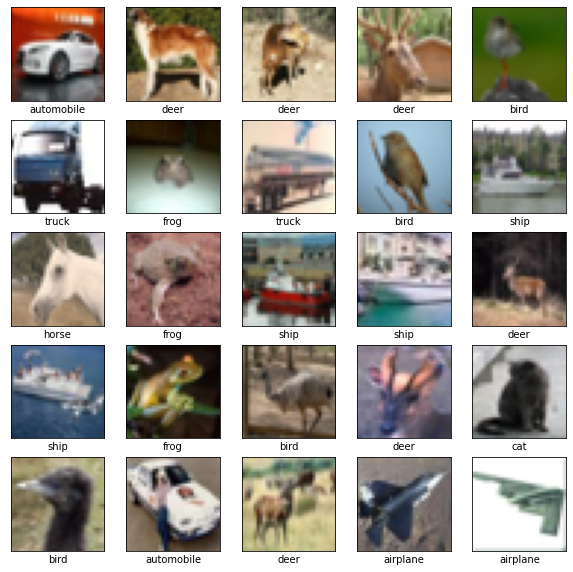

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')
  
  img_index = np.random.randint(0, 40000)
  plt.imshow(train_images[img_index])
  plt.xlabel(cifar_labels[train_labels[img_index]])

### Building a CNN

Finally, we build a simple convolutional architecture to classify the CIFAR images. We will build a mini version of the AlexNet architecture, which consists of 5 convolutional layers with max-pooling, followed by 3 fully-connected layers at the end. In order to investigate the effect each of these two layers have on the number of parameters, we'll build the model in two stages. 

First, the convolutional layers + max-pooling:

The hyper-parameters of a convolutional layer are as follows:
* **Filters** defines the number of filters in the layer. The filters are what is convolved over the input to recognise patterns. 
* **Kernel Size** defines the width and height of the filters (also called "kernels") in the layer. Note that kernels always have the same depth as the inputs to the layer.
* **Stride** defines the number of pixels by which we move the filter when "sliding" it along the input volume. Typically this value would be 1, but values of 2 and 3 are also sometimes used.
* **Padding** refers to the addition of 0-value pixels to the edges of the input volume along the width and height dimensions. In Tensorflow you can set this to "VALID", which essentially does no padding or "SAME" which pads the input such that the output width and height are the same as the input.



In [6]:
# Define the convolutinal part of the model architecture using Keras Layers.
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=48, kernel_size=(3, 3), activation=tf.nn.relu, input_shape=(32, 32, 3), padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=192, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.Conv2D(filters=192, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
])

How many parameters are there in the convolutional part of the architecture? We can easily inspect this using the model summary function in Keras:

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 48)        1344      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 48)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 128)       55424     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 192)         221376    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 192)         331968    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 128)         2

Now we add a fully-connected part. Note that we also add "Dropout" after the first fully-connected layer. Dropout is a regularisation technique which randomly zeros out ("drops") connections between neurons, and it was one of the key innovations of the AlexNet paper in 2012. Dropout is effective because it combats overfitting: random dropping of neurons forces the network to learn robust, general patterns, rather than model every peculiarity of the training data.

In [8]:
model.add(tf.keras.layers.Flatten())  # Flatten "squeezes" a 3-D volume down into a single vector.
model.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 48)        1344      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 48)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 128)       55424     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 192)         221376    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 192)         331968    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 128)         2

####Aside: Random initialisation schemes

You might have wondered what values we are using for the initial values of the weights and biases in our model. The short answer is that we typically use random initialisation. In this case, we have just been using the default keras initialisers for each layer, which are usually sufficient.

The longer answer is that just using completely random numbers does not always work best in practice and that there are a number of common initialisation schemes (which are available in most deep learning frameworks such as TensorFlow and Keras).

Lets consider a few examples:

 * When using the ReLU activation it is common to initialise the biases with small positive numbers (like the vector of 1s in the previous Task's compulsory exercise). This encourages the ReLU activations to start off in the _on_ state, which helps to counteract the _dying ReLU problem_. ReLU neurons "die" when a configuration of weights is such that that neuron only receive negative inputs, in which case it will always output zero and cannot contribute to the learning anymore.

 * The deeper neural networks become the more numbers are multiplied together. There is therefore a risk that gradients become smaller and smaller, in which case the network stops learning, or get bigger and bigger, in which case the network become imprecises. This shrink to the point that they vanish, or grow to the point that they overflow are called the _vanishing_ and _exploding_ gradient problems. To help combat this we can initialise our weights to have a (model-specific) appropriate scale. One method for doing this is called [_Xavier_ or _Glorot_](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) initialisation.

 * The _Xavier_ initialisation scheme was designed with the _traditional_ activations Sigmoid and TanH in mind, and does not work as well for ReLU activations. An alternative is [_He_](https://arxiv.org/pdf/1502.01852.pdf) initialisation which is a modification of _Xavier_ initialisation for ReLU activations.

 [This blog](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization) goes into more detail on _He_ and _Xavier_ initialisation. [The Keras documentation](https://keras.io/initializers/) lists a number of common schemes. 

### Visualising the model

Let's build a flow-diagram of the model we've constructed to see how information flows between the different layers.

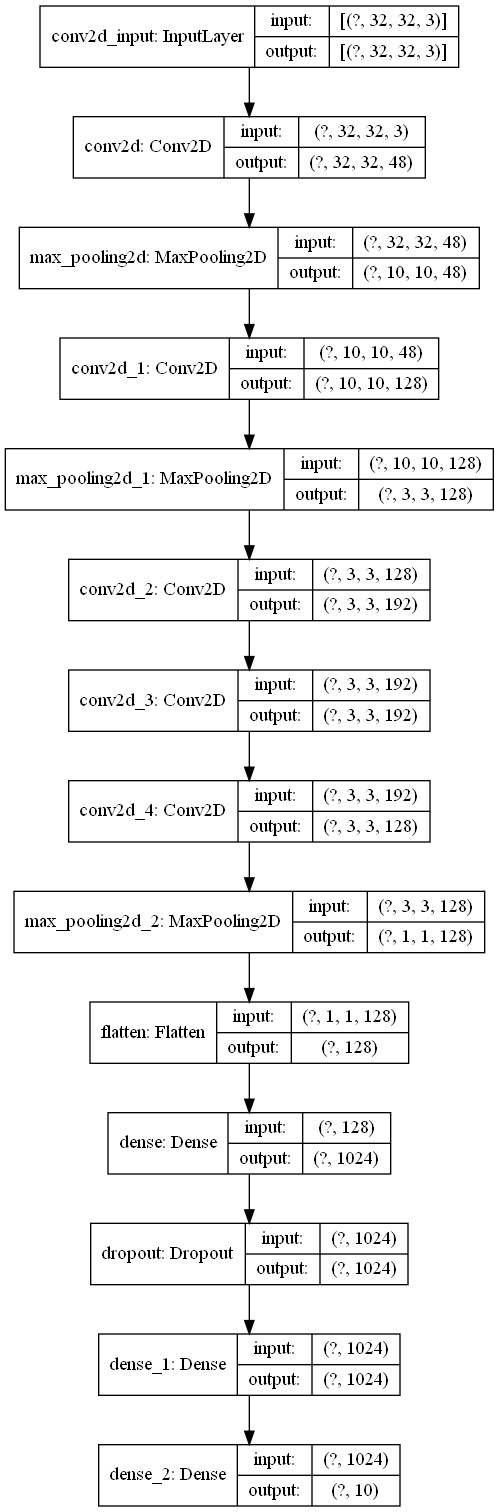

In [10]:
tf.keras.utils.plot_model(model, to_file='small_lenet.png', show_shapes=True, show_layer_names=True)
display.display(display.Image('small_lenet.png'))


### Training and Validating the model
In the last practical we had you write out the training-loop to give you a good appreciation for how it works. This time, we use the fitting method built-in to Keras. For simple, standard datasets like CIFAR, doing it this way will work fine, but it's important to know what goes on under the hood because you may need to write some or all of the steps out manually when working with more complex datasets! 

In [11]:
batch_size = 128
num_epochs = 10  # The number of epochs (full passes through the data) to train for

# Compiling the model adds a loss function, optimiser and metrics to track during training
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# The fit function allows you to fit the compiled model to some training data
model.fit(x=train_images, 
          y=train_labels, 
          batch_size=batch_size, 
          epochs=num_epochs, 
          validation_data=(validation_images, validation_labels.astype(np.float32)))

print('Training complete')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 62s 2ms/sample - loss: 1.7965 - acc: 0.3591 - val_loss: 1.3734 - val_acc: 0.5003
Epoch 2/10
40000/40000 [==============================] - 60s 1ms/sample - loss: 1.3162 - acc: 0.5292 - val_loss: 1.2248 - val_acc: 0.5705
Epoch 3/10
40000/40000 [==============================] - 62s 2ms/sample - loss: 1.1563 - acc: 0.5921 - val_loss: 1.2127 - val_acc: 0.5801
Epoch 4/10
40000/40000 [==============================] - 62s 2ms/sample - loss: 1.0418 - acc: 0.6380 - val_loss: 1.1343 - val_acc: 0.5982
Epoch 5/10
40000/40000 [==============================] - 63s 2ms/sample - loss: 0.9560 - acc: 0.6685 - val_loss: 1.0095 - val_acc: 0.6488
Epoch 6/10
40000/40000 [==============================] - 63s 2ms/sample - loss: 0.8793 - acc: 0.6942 - val_loss: 1.0260 - val_acc: 0.6520
Epoch 7/10
40000/40000

### Test performance
Finally, we evaluate how well the model does on the held-out test-set

In [12]:
metric_values = model.evaluate(x=test_images, y=test_labels)

print('Final TEST performance')
for metric_value, metric_name in zip(metric_values, model.metrics_names):
  print('{}: {}'.format(metric_name, metric_value))

10000/10000 [==============================] - 5s 499us/sample - loss: 1.0746 - acc: 0.6488
Final TEST performance
loss: 1.0745888781547546
acc: 0.6488000154495239


Note that we achieved roughly 80% training set accuracy, but our test accuracy is only around 67%. What do you think may be the reason for this?

### Classifying examples
We now use our trained model to classify a sample of 25 images from the test set. We pass these 25 images to the  ```model.predict``` function, which returns a [25, 10] dimensional matrix. The entry at position $(i, j)$ of this matrix contains the probability that image $i$ belongs to class $j$. We obtain the most-likely prediction using the ```np.argmax``` function which returns the index of the maximum entry along the columns. Finally, we plot the result with the prediction and prediction probability labelled underneath the image and true label on the side. 

In [13]:
img_indices = np.random.randint(0, len(test_images), size=[25])
sample_test_images = test_images[img_indices]
sample_test_labels = [cifar_labels[i] for i in test_labels[img_indices].squeeze()]

predictions = model.predict(sample_test_images)
max_prediction = np.argmax(predictions, axis=1)
prediction_probs = np.max(predictions, axis=1)

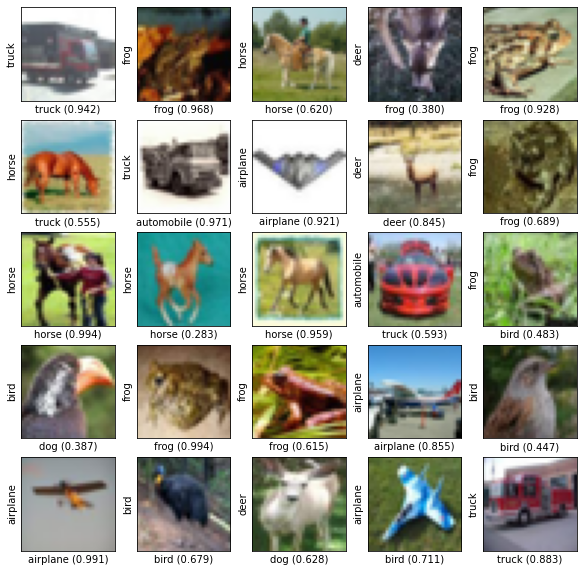

In [14]:
plt.figure(figsize=(10,10))
for i, (img, prediction, prob, true_label) in enumerate(
    zip(sample_test_images, max_prediction, prediction_probs, sample_test_labels)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')

  plt.imshow(img)
  plt.xlabel('{} ({:0.3f})'.format(cifar_labels[prediction], prob))
  plt.ylabel('{}'.format(true_label))
  

### Aside: Uncertainty in deep learning

Deep neural networks are not considered to be very good at estimating the uncertainty in their predictions. However, knowing your model's uncertainty can be very important for many applications. For example, consider a deep learning tool for diagnosing diseases, in this case a false negative could have massive impacts on a person's life! We would really like to know how confident our model is in its prediction. This is a budding field of research, for example see [this blog](https://www.cs.ox.ac.uk/people/yarin.gal/website/blog_3d801aa532c1ce.html) for a nice introduction.

### Aside: CNN architectures

Deciding on the architecture for a CNN, i.e. the combination of convolution, pooling, dense, and other layers, can be tricky and often can seem arbitrary. On top of that, one also has to make decisions such as what kind of pooling, which activation functions, and what size of convolution to use, among other things. For new and old practitioners of deep learning, these choices can be overwhelming. 

However, by examining existing successful CNN architectures we can learn a lot about what works and what doesn't. (We can even apply these existing architectures to our problems since many deep learning libraries, such as TensorFlow and Keras, have them [built in](https://keras.io/applications/#available-models) and it is even possible to fine-tune pre-trained models to our specific problem using [transfer learning](https://cs231n.github.io/transfer-learning/).)

[This article](https://medium.com/@sidereal/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5) describes many of the most successful CNN architectures in recent years, including [ResNet](https://arxiv.org/abs/1512.03385), [Inception](https://arxiv.org/pdf/1512.00567v3.pdf) and [VGG](https://arxiv.org/pdf/1409.1556.pdf). For a more detailed and technical description of these models and more see [these slides](http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture9.pdf). Reading through these resources should give you insights into why these architectures are successful as well as best practices and current trends for CNNs that will help you design your own architectures.




## Your Tasks

1. Experiment with the network architecture, try changing the numbers, types and sizes of layers, the sizes of filters, using different padding etc. How do these decisions affect the performance of the model? In particular, try building a *fully convolutinoal* network, with no (max-)pooling layers. 
2.  Implement BATCH NORMALISATION ([Tensorflow documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) and [research paper](http://proceedings.mlr.press/v37/ioffe15.pdf)) to improve the model's generalisation.

5. Why do modern architectures use less max-pooling?
6. What does a 1x1 convolution do?
7. What is a residual connection?

##Additional Resources for your own time

Here's some more information on ConvNets:

* Chris Colah's blog post on [Understanding Convolutions](https://colah.github.io/posts/2014-07-Understanding-Convolutions/)
* [How do convolutional neural networks work?](http://brohrer.github.io/how_convolutional_neural_networks_work.html)
* The [CS231n course](https://cs231n.github.io/)
* [Building blocks of interpretability](https://distill.pub/2018/building-blocks/)



In [15]:
train_images.shape

(40000, 32, 32, 3)

In [16]:
def model_initializer(pading, activation,SIZE, filters_main, other_filters, maxpooling=False ):
   
    #check if  maxpooling is set to true or false
    #if True  => add the pooling layer to our CNN
    if maxpooling  == True:
        #build the model with maxpooling layers
        model_= tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(filters=filters_main, kernel_size=SIZE, activation=activation, input_shape=(32, 32, 3), padding=pading),
            tf.keras.layers.MaxPooling2D(pool_size=SIZE),
            tf.keras.layers.Conv2D(filters=other_filters, kernel_size=SIZE, activation=activation, padding=pading),
            tf.keras.layers.MaxPooling2D(pool_size=SIZE),
            tf.keras.layers.Conv2D(filters=other_filters, kernel_size=SIZE, activation=activation, padding=pading),
            tf.keras.layers.Conv2D(filters=other_filters, kernel_size=SIZE, activation=activation, padding=pading),
            tf.keras.layers.Conv2D(filters=other_filters, kernel_size=SIZE, activation=activation, padding=pading),
            tf.keras.layers.MaxPooling2D(pool_size=SIZE),
        ])
        


    #run the CNN without maxpooling layers
    else:
        #we 
        model_ = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(filters=filters_main, kernel_size=SIZE, activation=activation, input_shape=(32, 32, 3), padding=pading),
            
            #add in batch-normalization layers =>
            #to speed up the training process and increase accuracy)
            
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(filters=other_filters, kernel_size=SIZE, activation=activation, padding=pading),
            
            tf.keras.layers.BatchNormalization(),
            
            
            tf.keras.layers.Dropout(rate=0.5),
            
            
            tf.keras.layers.Flatten(),  # Flatten ("squeezes") a 3-D volume down into a single vector.
            tf.keras.layers.Dense(10, activation=tf.nn.softmax),

            
            
            
        ])
        
    return model_

In [17]:
#create a function to visualize the model
def visualize_model(model):
    
    tf.keras.utils.plot_model(model, to_file='small_lenet.png', show_shapes=True, show_layer_names=True)
    display.display(display.Image('small_lenet.png'))

In [18]:

#Parameters for model_initializer func.

SIZE=(1,1)
filters_main=5
pading = 'valid'
activation = 'relu'
other_filters =192
model_ = model_initializer(pading, activation,SIZE, filters_main, other_filters, maxpooling=True )



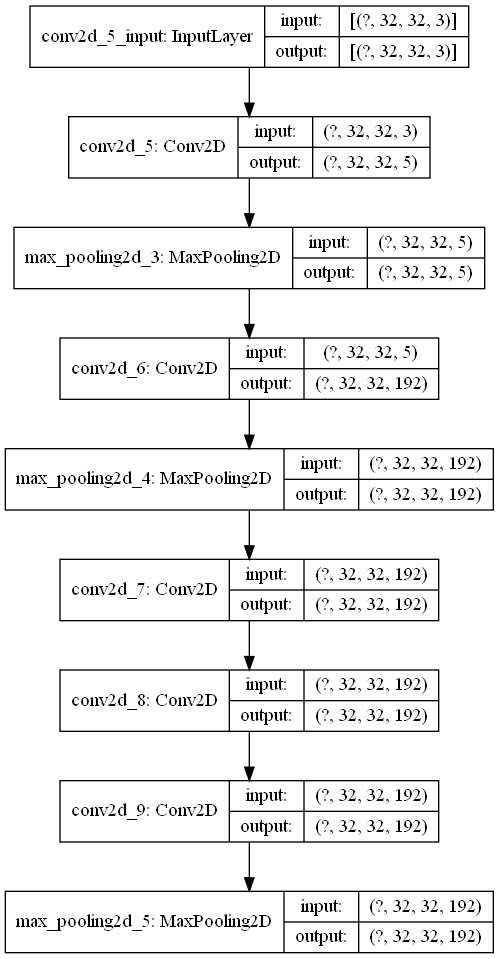

In [19]:
visualize_model(model_)

In [25]:
#view summary 
model_.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 5)         20        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 5)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 192)       1152      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 192)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 192)       37056     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 192)       37056     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 192)      

In [22]:



batch_size = 128
num_epochs = 10  # The number of epochs (full passes through the data) to train for

# Compiling the model adds a loss function, optimiser and metrics to track during training
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# The fit function allows you to fit the compiled model to some training data
model.fit(x=train_images, 
          y=train_labels, 
          batch_size=batch_size, 
          epochs=num_epochs, 
          validation_data=(validation_images, validation_labels.astype(np.float32)))

print('Training complete')


Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 59s 1ms/sample - loss: 0.5549 - acc: 0.8082 - val_loss: 1.0958 - val_acc: 0.6771
Epoch 2/10
40000/40000 [==============================] - 58s 1ms/sample - loss: 0.5130 - acc: 0.8259 - val_loss: 1.1225 - val_acc: 0.6706
Epoch 3/10
40000/40000 [==============================] - 59s 1ms/sample - loss: 0.4574 - acc: 0.8429 - val_loss: 1.1396 - val_acc: 0.6718
Epoch 4/10
40000/40000 [==============================] - 59s 1ms/sample - loss: 0.4175 - acc: 0.8580 - val_loss: 1.2578 - val_acc: 0.6743
Epoch 5/10
40000/40000 [==============================] - 59s 1ms/sample - loss: 0.3625 - acc: 0.8753 - val_loss: 1.2492 - val_acc: 0.6760
Epoch 6/10
40000/40000 [==============================] - 59s 1ms/sample - loss: 0.3473 - acc: 0.8824 - val_loss: 1.3022 - val_acc: 0.6694
Epoch 7/10
40000/40000 [==============================] - 60s 1ms/sample - loss: 0.3227 - acc: 0.8909 - val_loss: 1.

we build a model without max-pooling

In [26]:
#reset the parameter and turn off the maxpooling
SIZE=(3,3)
filters_main=128
pading = 'valid'
activation = 'relu'
other_filters =192
model_1 = model_initializer(pading, activation,SIZE, filters_main, other_filters, maxpooling=False )

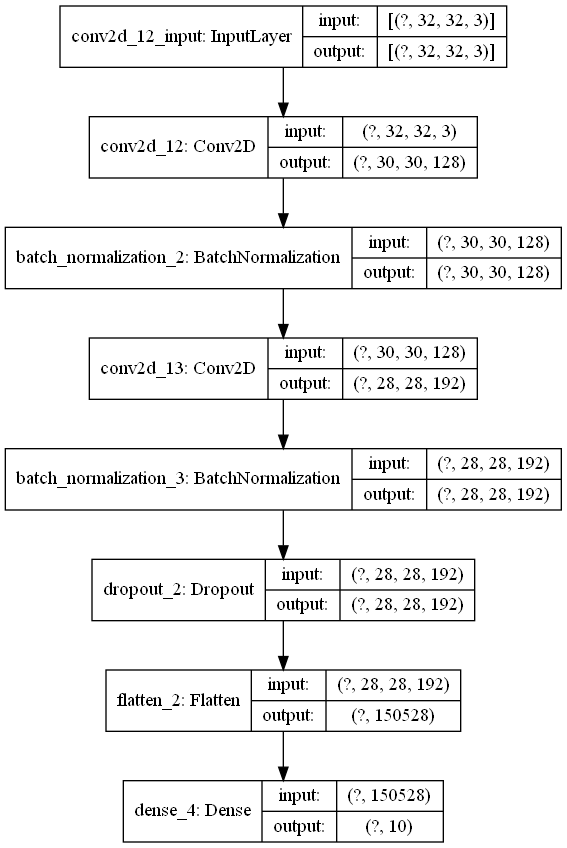

In [27]:


#plot the model using our vizualize model function created earlier
visualize_model(model_1)



In [28]:
#inspect our model

model_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 128)       512       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 192)       221376    
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 192)       768       
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 28, 192)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

In [29]:
batch_size = 125 #amount of data we want  to load at a time
num_epochs = 10  # The number of epochs (full passes through the data) to train for

# Compiling the model adds a loss function, optimiser and metrics to track during training
model_1.compile(optimizer=tf.train.AdamOptimizer(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

# now let's train our model
model_1.fit(x=train_images, 
          y=train_labels, 
          batch_size=batch_size, 
          epochs=10, 
          validation_data=(validation_images, validation_labels))

print('Training complete')

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 687s 17ms/sample - loss: 4.3669 - acc: 0.4167 - val_loss: 1.7899 - val_acc: 0.5017
Epoch 2/10
40000/40000 [==============================] - 678s 17ms/sample - loss: 1.7199 - acc: 0.5532 - val_loss: 1.3555 - val_acc: 0.5969
Epoch 3/10
40000/40000 [==============================] - 682s 17ms/sample - loss: 1.5539 - acc: 0.5970 - val_loss: 1.6767 - val_acc: 0.5307
Epoch 4/10
40000/40000 [==============================] - 678s 17ms/sample - loss: 1.4010 - acc: 0.6320 - val_loss: 1.4999 - val_acc: 0.5774
Epoch 5/10
40000/40000 [==============================] - 674s 17ms/sample - loss: 1.2785 - acc: 0.6693 - val_loss: 1.3264 - val_acc: 0.6157
Epoch 6/10
40000/40000 [==============================] - 681s 17ms/sample - loss: 1.1519 - acc: 0.6964 - val_loss: 1.4713 - val_acc: 0.5994
Epoch 7/10
40000/40000 [==============================] - 681s 17ms/sample - loss: 1.2057 - acc: 0.6944 

##It is noted that the amount of time taken for our model to learn is longer.

In [30]:

#evaluate our model
metric_values = model_1.evaluate(x=test_images, y=test_labels)

#display the final result
print('Final TEST performance')
for metric_value, metric_name in zip(metric_values, model.metrics_names):
    print('{}: {}'.format(metric_name, metric_value))

10000/10000 [==============================] - 32s 3ms/sample - loss: 1.3718 - acc: 0.6257
Final TEST performance
loss: 1.3717767762184143
acc: 0.6256999969482422


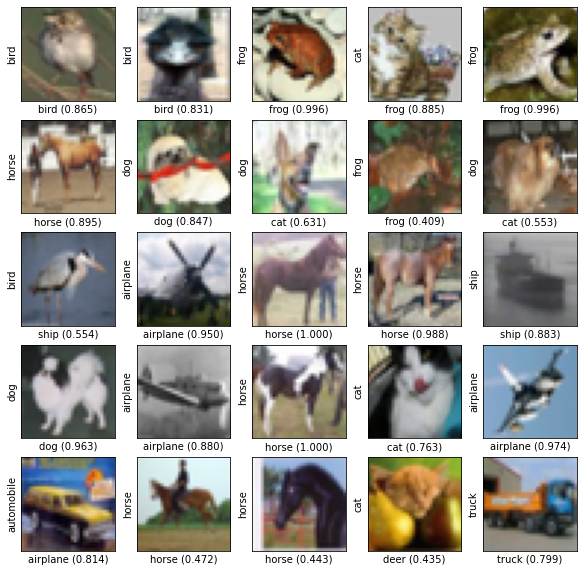

In [31]:
#we look at the ability of our model to predict what an object is

#generate random samples
img_indices = np.random.randint(0, len(test_images), size=[25])
sample_test_images = test_images[img_indices]
sample_test_labels = [cifar_labels[i] for i in test_labels[img_indices].squeeze()]

#test the model on the samples collected
predictions = model_1.predict(sample_test_images)
max_prediction = np.argmax(predictions, axis=1)
prediction_probs = np.max(predictions, axis=1)

# display the result predicted vs the real image
plt.figure(figsize=(10,10))
for i, (img, prediction, prob, true_label) in enumerate(
    zip(sample_test_images, max_prediction, prediction_probs, sample_test_labels)):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off')

    plt.imshow(img)
    plt.xlabel('{} ({:0.3f})'.format(cifar_labels[prediction], prob))
    plt.ylabel('{}'.format(true_label))

# Why do morden architectures use less max-pooling ?



In [29]:
#It is because in this method The results are down sampled or pooled feature maps that highlight the most present feature
#in the patch, not the average presence of the feature in the case of average pooling.

#is based on the idea of simplifying the process of pooling the max value in a given array, 
#hence it discard important info that could be useful when looking for variance in the data. 

# What does a 1 by 1 convulution do ?



In [ ]:
#a 1*1 convulution returns an output image with the same dimensions as the input image.

#colored images have three dimensions, or channels, a 1*1 convulutions compress these
#channels at little cost, leaving a 2D image to perform expensive 3 by 3 and 5*5 convulutions on.

# What is a residual connection?

#A residual connection is integrated into the deep separable CNN so that the features obtained in the lower layers can be transmitted to the upper neural network layers. This thereby would effectively avoid the bottleneck problem of the features in upper layer.
